In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import onnx
import onnx_tf
import onnxruntime

rng = np.random.default_rng()

In [2]:
import scipy.stats.qmc

# Study whether QMC sampling can improve distillation efficieny

## Data-Free case

In [3]:
acas_xu = onnx.load("/Users/jperrsau/cu-src/thesis/src/nnenum/examples/acasxu/data/ACASXU_run2a_1_1_batch_2000.onnx")

acas_xu = onnx_tf.backend.prepare(acas_xu)

inputs = (rng.random((4096,1,1,5),dtype="float32")-0.5)*2
#inputs = (np.array(scipy.stats.qmc.Sobol(5).random_base2(int(np.log2(2048))), dtype="float32").reshape((2048,1,1,5))-0.5)*2

onnx_outputs = acas_xu.run(inputs)

outputs = onnx_outputs.linear_7_Add

2022-10-17 11:26:52.998270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train student network using Data-Free Distillation

In [5]:
## Generate synthetic dataset using a random distribution.

synthetic_inputs = (rng.random((4096,1,1,5),dtype="float32")-0.5)*2

onnx_outputs = acas_xu.run(synthetic_inputs)

synthetic_inputs_train = synthetic_inputs.reshape((4096,5))[:3000]
synthetic_outputs_train = onnx_outputs.linear_7_Add[:3000]


synthetic_inputs_val = synthetic_inputs.reshape((4096,5))[3000:]
synthetic_outputs_val = onnx_outputs.linear_7_Add[3000:]


In [41]:
## Acas XU original is 8 hidden layers with 300 relu each
#Katz, G., Barrett, C., Dill, D.L., Julian, K., Kochenderfer, M.J. (2017). Reluplex: An Efficient SMT Solver for Verifying Deep Neural Networks. In: Majumdar, R., Kunčak, V. (eds) Computer Aided Verification. CAV 2017. Lecture Notes in Computer Science(), vol 10426. Springer, Cham. https://doi.org/10.1007/978-3-319-63387-9_5

hidden_layer_width=50
num_hidden_layers=8

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(5,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(5))

student_model = tf.keras.Sequential(layers)

student_model.summary()

## Julian K uses an asymmetric loss function based on MSE. We use MSE here for now.

student_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.KLDivergence(),
    metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.KLDivergence(), tf.keras.metrics.CategoricalCrossentropy()],
    optimizer=tf.keras.optimizers.Adam(0.001)
)

history = student_model.fit(
    x=synthetic_inputs_train,
    y=synthetic_outputs_train,#synthetic_outputs, #- Using logits in the loss function requires a different loss metric, like KLDivergence. But I couldn't get it working immediately.
    epochs=500,
    batch_size=128,
    verbose=0,
    validation_data = (synthetic_inputs_val, synthetic_outputs_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ],
    )


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 50)                300       
                                                                 
 dense_65 (Dense)            (None, 50)                2550      
                                                                 
 dense_66 (Dense)            (None, 50)                2550      
                                                                 
 dense_67 (Dense)            (None, 50)                2550      
                                                                 
 dense_68 (Dense)            (None, 50)                2550      
                                                                 
 dense_69 (Dense)            (None, 50)                2550      
                                                                 
 dense_70 (Dense)            (None, 50)               

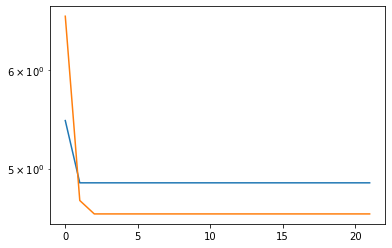

In [40]:
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.yscale("log")

In [37]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'kullback_leibler_divergence', 'categorical_crossentropy', 'val_loss', 'val_mean_squared_error', 'val_kullback_leibler_divergence', 'val_categorical_crossentropy'])

In [7]:
synthetic_outputs_pred = student_model.predict(synthetic_inputs)

plt.scatter(synthetic_inputs[:,0], synthetic_inputs[:,1], c=synthetic_outputs_pred[:,0])
plt.title("Teacher Model Output 0 projected on to Input 0 and Input 1")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.colorbar()
plt.show()

plt.scatter(synthetic_inputs[:,0], synthetic_inputs[:,1], c=synthetic_outputs[:,0])
plt.title("Student Model Output 0 projected on to Input 0 and Input 1")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.colorbar()
plt.show()

plt.scatter(synthetic_inputs[:,0], synthetic_inputs[:,1], c=synthetic_outputs[:,0]-synthetic_outputs_pred[:,0],cmap="inferno_r")
plt.title("Delta")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.colorbar()
plt.show()

ValueError: in user code:

    File "/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 5), found shape=(32, 1, 1, 5)


In [8]:
(synthetic_outputs - synthetic_outputs_pred)[:,0].max()

0.17402053

In [9]:
np.linalg.norm(synthetic_outputs, axis=1).mean()

1.6487188

In [10]:
np.linalg.norm((synthetic_outputs - synthetic_outputs_pred), axis=1).max()

0.6327621

## Measure the Closeness of student and teacher networks

In [11]:
student_model, acas_xu

(<keras.engine.sequential.Sequential at 0x1404dcf70>,
 <onnx_tf.backend_rep.TensorflowRep at 0x14027cb50>)

In [12]:
synthetic_inputs = (rng.random((2000,1,1,5),dtype="float32")-0.5)*2
# synthetic_inputs = scipy.qmc.sobol()

onnx_outputs = acas_xu.run(synthetic_inputs)
synthetic_inputs = synthetic_inputs.reshape((2000,5))
synthetic_outputs_teacher = onnx_outputs.linear_7_Add

synthetic_outputs_student = student_model.predict(synthetic_inputs)

63/63 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Error Distribution (MSE)')

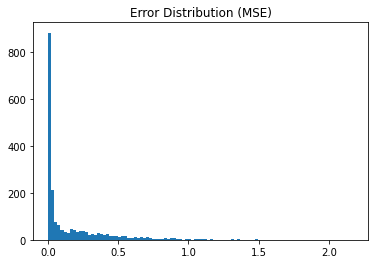

In [13]:
diff = np.sqrt(np.sum((synthetic_outputs_teacher - synthetic_outputs_student)**2, axis=1))
#diff = np.max(np.abs(synthetic_outputs_teacher - synthetic_outputs_student), axis=1) #infinity norm

plt.hist(diff, bins=100)

plt.title("Error Distribution (MSE)")

## Probably gamma or beta distributed?

In [14]:
np.quantile(diff, 0.99)

1.169281154870987

In [15]:
p99 = []
points_per_iteration = 2000

for mc_iteration in range(100):

    synthetic_inputs = (rng.random((points_per_iteration,1,1,5),dtype="float32")-0.5)*2

    onnx_outputs = acas_xu.run(synthetic_inputs)
    synthetic_inputs = synthetic_inputs.reshape((points_per_iteration,5))
    synthetic_outputs_teacher = onnx_outputs.linear_7_Add
    synthetic_outputs_student = student_model.predict(synthetic_inputs)

    diff = np.sqrt(np.sum((synthetic_outputs_teacher - synthetic_outputs_student)**2, axis=1))
    p99.append(np.quantile(diff, 0.99))


63/63 [==============================] - 0s 2ms/step


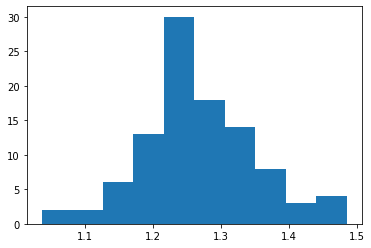

In [16]:
plt.hist(p99, bins=10)
plt.show()

In [17]:
np.mean(p99), np.std(p99)

(1.2671367528915405, 0.08229062140355549)

In [18]:
np.std(p99) * 2.58

0.21230980322117315

## Verify student and teacher networks

Use the 10 properties provided in VNNComp to check if the student network satisfies the safety properties. Produce the following:

- Timing information
- Counterexamples
- Failiure modes of nnenum
- List of verified networks

## NNenum

In [19]:
tf.saved_model.save(student_model, "./distill_qmc_closeness_acas_student_model")

INFO:tensorflow:Assets written to: ./distill_qmc_closeness_acas_student_model/assets


In [20]:
!python -m tf2onnx.convert --saved-model ./distill_qmc_closeness_acas_student_model/ --output distill_qmc_closeness_acas_student_model.onnx --opset 11

/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-10-05 10:05:58,696 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-10-05 10:05:59,022 - INFO - Signatures found in model: [serving_default].
2022-10-05 10:05:59,022 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-10-05 10:05:59,023 - INFO - Output names: ['dense_4']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-10-05 10:05:59,087 - WARNING - From /Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.comp

In [22]:
!docker run -it -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_qmc_closeness_acas_student_model.onnx /my_work/data/acasxu/prop_1.vnnlib

all input names: ['dense_input', 'StatefulPartitionedCall/sequential/dense/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/MatMul:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense/Relu:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_1/Relu:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_2/Relu:0', 'StatefulPartitionedCall/sequential/dense_3/MatMul/ReadVariabl

In [23]:
!docker run -it -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /my_work/data/acasxu/prop_1.vnnlib

all input names: ['input', 'input_AvgImg', 'input_Sub', 'Operation_1_Flatten', 'Operation_1_MatMul_W', 'Operation_1_MatMul', 'Operation_1_Add_B', 'Operation_1_Add', 'relu_1', 'Operation_2_MatMul_W', 'Operation_2_MatMul', 'Operation_2_Add_B', 'Operation_2_Add', 'relu_2', 'Operation_3_MatMul_W', 'Operation_3_MatMul', 'Operation_3_Add_B', 'Operation_3_Add', 'relu_3', 'Operation_4_MatMul_W', 'Operation_4_MatMul', 'Operation_4_Add_B', 'Operation_4_Add', 'relu_4', 'Operation_5_MatMul_W', 'Operation_5_MatMul', 'Operation_5_Add_B', 'Operation_5_Add', 'relu_5', 'Operation_6_MatMul_W', 'Operation_6_MatMul', 'Operation_6_Add_B', 'Operation_6_Add', 'relu_6', 'linear_7_MatMul_W', 'linear_7_MatMul', 'linear_7_Add_B']
Running in parallel with 6 processes
(0.1 sec) Q: 0, Sets: 0/1  (0.0%) ETA: - (expected 1 stars)   
(0.2 sec) Q: 0, Sets: 0/5  (0.0%) ETA: - (expected 1 stars)   
(0.4 sec) Q: 8, Sets: 47/77  (22.377%) ETA: 1.2 sec (expected 210 stars)   
(0.8 sec) Q: 0, Sets: 283/287  (95.898%) ETA: 0.

## All 10 properties with timing

In [24]:
import subprocess
import re

In [25]:
for prop in range(1,10+1):
    print(f"Property {prop}")

    cmd = f"docker run -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_qmc_closeness_acas_student_model.onnx /my_work/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
    result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
    print(f"\tStudent:\tTime={runtime_re}\tOutput={result_re}")

    cmd = f"docker run -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /my_work/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
    result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
    print(f"\tTeacher:\tTime={runtime_re}\tOutput={result_re}")


    

Property 1
	Student:	Time=0.3	Output=network is SAFE
	Teacher:	Time=0.6	Output=network is SAFE
Property 2
	Student:	Time=1.1	Output=network is SAFE
	Teacher:	Time=1.3	Output=network is SAFE
Property 3
	Student:	Time=0.1	Output=network is SAFE
	Teacher:	Time=2.3	Output=network is SAFE
Property 4
	Student:	Time=0.4	Output=network is SAFE
	Teacher:	Time=1.2	Output=network is SAFE
Property 5
	Student:	Time=0.4	Output=network is SAFE
	Teacher:	Time=4.2	Output=network is SAFE
Property 6
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=9.4	Output=network is SAFE
Running in parallel with 
Property 7
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
Property 8
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
Prop

### What do the counterexamples look like?

In [26]:
prop = 4

print(f"Property {prop}")
cmd = f"docker run -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_qmc_closeness_acas_student_model.onnx /my_work/data/acasxu/prop_{prop}.vnnlib"
result = subprocess.getoutput(cmd)
print(result)



    

Property 4
all input names: ['dense_input', 'StatefulPartitionedCall/sequential/dense/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/MatMul:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense/Relu:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_1/Relu:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_2/Relu:0', 'StatefulPartitionedCall/sequential/dense_3/MatMul/